<a href="https://colab.research.google.com/github/Sidhtang/FINANCIAL-MODEL-using-machine-learning/blob/main/arima_and_lstm_combine_model_for_crypto_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of replicas: 1
Loading and preprocessing data...


<ipython-input-3-93312aa18064>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
<ipython-input-3-93312aa18064>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Training data shape: (1812332, 16)
Test data shape: (909616, 16)

Running ARIMA model...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA (Train) Results:
F1 Score: 0.4885
Accuracy: 0.4996
Confusion Matrix:
 [[472538 474401]
 [432441 432951]]

ARIMA (Test) Results:
F1 Score: 0.0002
Accuracy: 0.5801
Confusion Matrix:
 [[527579     44]
 [381948     44]]


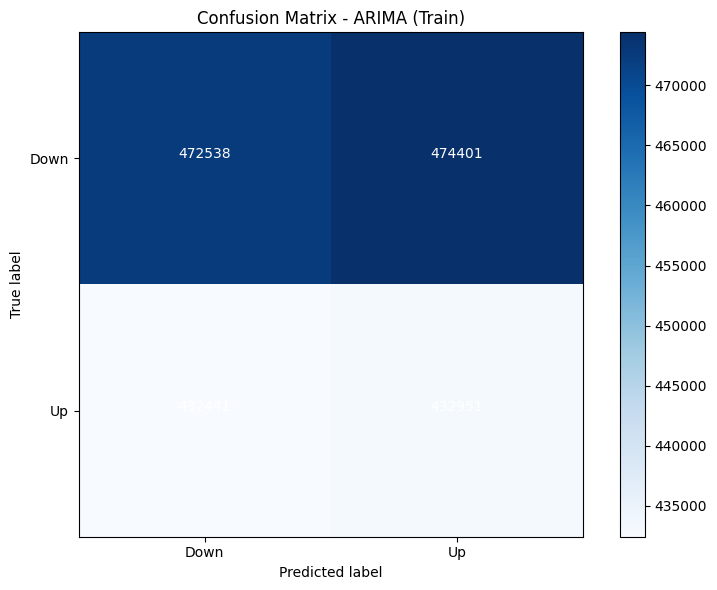

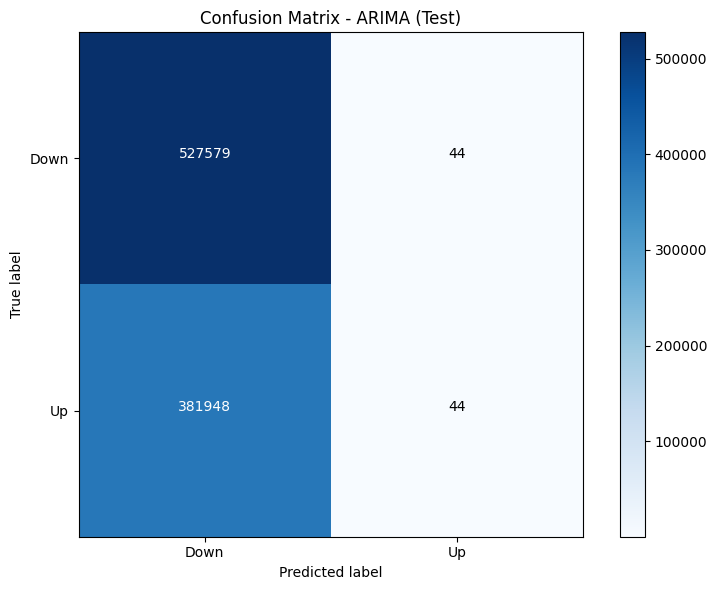


Running LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 481s 8ms/step - accuracy: 0.5382 - loss: 0.6875 - val_accuracy: 0.5801 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 2/50
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 496s 8ms/step - accuracy: 0.5385 - loss: 0.6863 - val_accuracy: 0.5801 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 3/50
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 509s 8ms/step - accuracy: 0.5393 - loss: 0.6856 - val_accuracy: 0.5796 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 4/50
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 511s 9ms/step - accuracy: 0.5392 - loss: 0.6857 - val_accuracy: 0.5699 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 5/50
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 480s 8ms/step - accuracy: 0.5397 - loss: 0.6856 - val_accuracy: 0.5335 - val_loss: 0.6910 - learning_rate: 5.0000e-04
Epoch 6/50
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 513s 9ms/step - accuracy: 0.5397 - loss: 0.6853 - val_accuracy: 0.5437 - val_loss: 0.6908 - learning_rate: 5.0000e-04
56636/56636 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/st

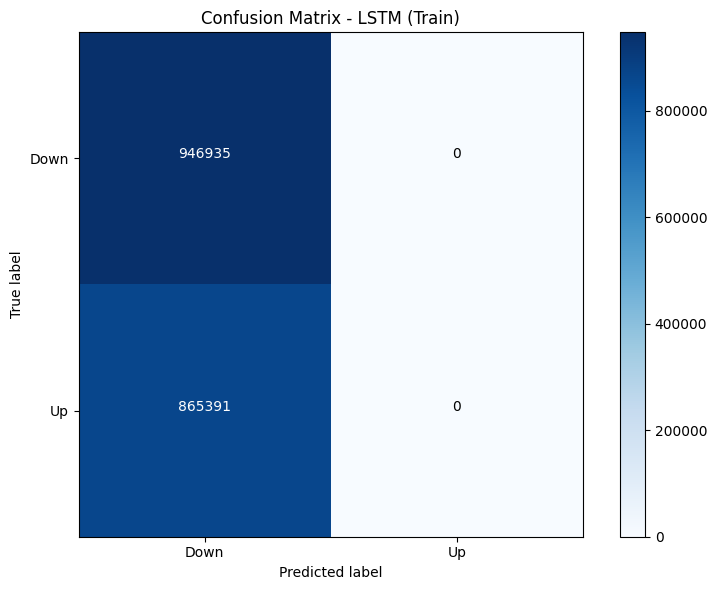

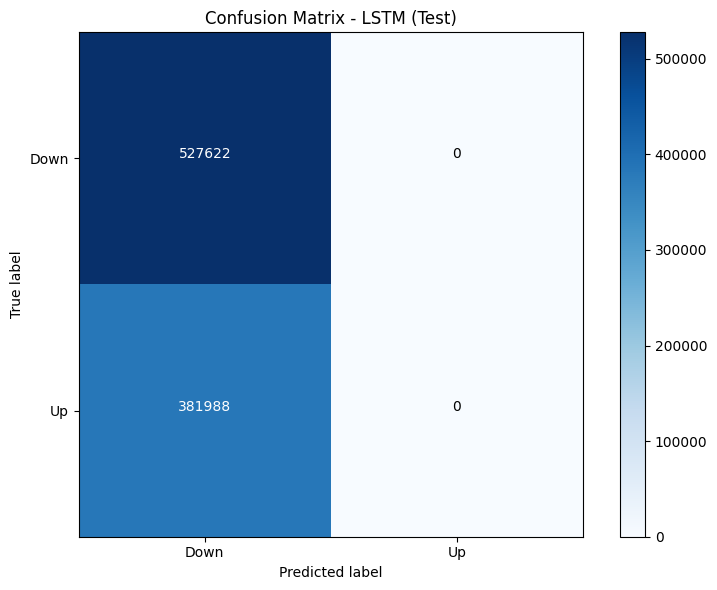

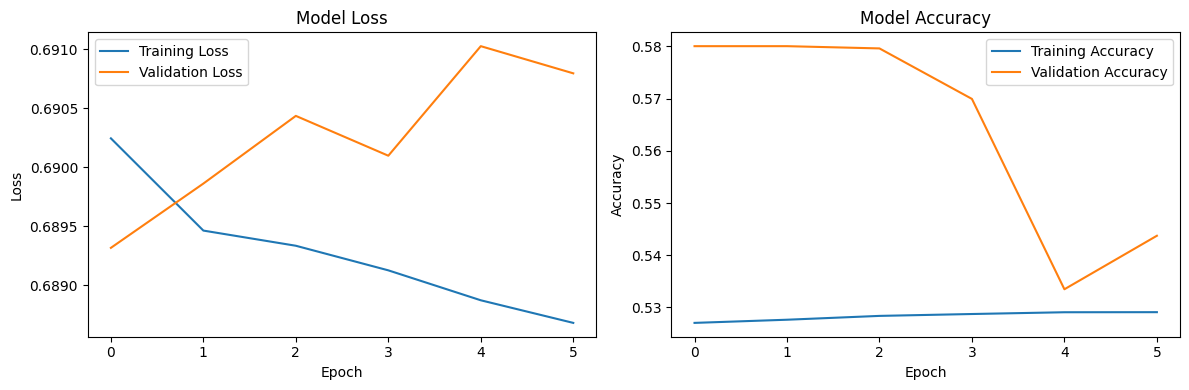

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

# TPU setup remains the same
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

def preprocess_data(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.dropna()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Add technical indicators
    df['SMA_5'] = df['close'].rolling(window=5).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['RSI'] = calculate_rsi(df['close'])
    df['MACD'] = calculate_macd(df['close'])

    # Fill NaN values created by indicators
    df = df.fillna(method='bfill')
    return df

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    return exp1 - exp2

def add_price_direction(df):
    # Ensure we don't create a label for the last row
    df['price_direction'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)
    # Remove the last row since it will have NaN in price_direction
    return df.iloc[:-1].copy()

def run_arima(train_data, test_data, order=(2, 1, 2)):
    # Fit ARIMA model on the training data
    model = ARIMA(train_data, order=order)
    results = model.fit()

    # Generate forecasts for both training and test sets
    train_forecast = results.fittedvalues
    test_forecast = results.forecast(steps=len(test_data))

    # Convert to direction predictions
    train_direction = (np.diff(np.concatenate([[train_data.iloc[0]], train_forecast])) > 0).astype(int)
    test_direction = (np.diff(np.concatenate([[test_data.iloc[0]], test_forecast])) > 0).astype(int)

    # Ensure lengths match
    train_direction = train_direction[:len(train_data)-1]  # Remove last prediction
    test_direction = test_direction[:len(test_data)-1]  # Remove last prediction

    return train_direction, test_direction

def create_dataset(dataset, look_back=5):
    """Create sequences of data for LSTM"""
    features = dataset.shape[1]
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, -1])  # Last column is the target
    return np.array(X), np.array(Y)

def prepare_lstm_data(train_df, test_df, look_back=5):
    """Prepare data for LSTM including scaling"""
    feature_columns = ['close', 'SMA_5', 'SMA_20', 'RSI', 'MACD']
    target_column = ['price_direction']

    # Combine features and target
    train_data = np.concatenate([
        train_df[feature_columns].values,
        train_df[target_column].values
    ], axis=1)

    test_data = np.concatenate([
        test_df[feature_columns].values,
        test_df[target_column].values
    ], axis=1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Create sequences
    X_train, y_train = create_dataset(train_scaled, look_back)
    X_test, y_test = create_dataset(test_scaled, look_back)

    return X_train, y_train, X_test, y_test

def run_lstm(train_df, test_df, look_back=5):
    # Prepare data
    X_train, y_train, X_test, y_test = prepare_lstm_data(train_df, test_df, look_back)

    # Convert to tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, input_shape=(look_back, X_train.shape[2]), return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(50, return_sequences=False),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.0001
        )
    ]

    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=1
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Convert predictions to binary
    train_pred = (train_pred > 0.5).astype(int)
    test_pred = (test_pred > 0.5).astype(int)

    return train_pred, test_pred, y_train, y_test, history

def evaluate_model(y_true, y_pred, model_name):
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n", cm)
    return f1, accuracy, cm

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Down', 'Up'])
    plt.yticks(tick_marks, ['Down', 'Up'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add text annotations
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    train_df = pd.read_csv('/content/train[1].csv')
    test_df = pd.read_csv('/content/test.csv')

    # Preprocess both datasets
    train_df = preprocess_data(train_df)
    test_df = preprocess_data(test_df)

    # Add price direction and remove last row
    train_df = add_price_direction(train_df)
    test_df = add_price_direction(test_df)

    print("Training data shape:", train_df.shape)
    print("Test data shape:", test_df.shape)

    # ARIMA model
    print("\nRunning ARIMA model...")
    arima_train_pred, arima_test_pred = run_arima(
        train_df['close'],
        test_df['close']
    )

    # Evaluate ARIMA results
    arima_train_metrics = evaluate_model(
        train_df['price_direction'].iloc[:len(arima_train_pred)],
        arima_train_pred,
        "ARIMA (Train)"
    )
    arima_test_metrics = evaluate_model(
        test_df['price_direction'].iloc[:len(arima_test_pred)],
        arima_test_pred,
        "ARIMA (Test)"
    )

    # Plot ARIMA confusion matrices
    plot_confusion_matrix(arima_train_metrics[2], "ARIMA (Train)")
    plot_confusion_matrix(arima_test_metrics[2], "ARIMA (Test)")

    # LSTM model
    print("\nRunning LSTM model...")
    lstm_train_pred, lstm_test_pred, lstm_y_train, lstm_y_test, history = run_lstm(
        train_df,
        test_df
    )

    # Evaluate LSTM results
    lstm_train_metrics = evaluate_model(
        lstm_y_train,
        lstm_train_pred.flatten(),
        "LSTM (Train)"
    )
    lstm_test_metrics = evaluate_model(
        lstm_y_test,
        lstm_test_pred.flatten(),
        "LSTM (Test)"
    )

    # Plot LSTM results
    plot_confusion_matrix(lstm_train_metrics[2], "LSTM (Train)")
    plot_confusion_matrix(lstm_test_metrics[2], "LSTM (Test)")
    plot_training_history(history)

if __name__ == "__main__":
    main()

In [24]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

class PricePredictionModel:
    def __init__(self):
        self.lstm_model = None
        self.arima_model = None
        self.scaler = None
        self.look_back = 5
        self.feature_columns = ['close', 'SMA_5', 'SMA_20', 'RSI', 'MACD']

    def create_lstm_model(self):
        """Create LSTM model with proper architecture"""
        inputs = tf.keras.Input(shape=(self.look_back, len(self.feature_columns)))
        x = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.LSTM(32)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def save_models(self, lstm_model, arima_model, scaler, path='./models/'):
        """Save trained models and scaler"""
        try:
            # Create directory if it doesn't exist
            import os
            os.makedirs(path, exist_ok=True)

            # Save LSTM model weights only
            lstm_model.save_weights(f'{path}lstm_weights.keras')

            # Save ARIMA model
            joblib.dump(arima_model, f'{path}arima_model.pkl')

            # Save scaler
            joblib.dump(scaler, f'{path}scaler.pkl')

            print("Models saved successfully!")

        except Exception as e:
            print(f"Error saving models: {e}")

    def load_models(self, path='./models/'):
        """Load trained models and scaler"""
        try:
            # Create new model instance
            self.lstm_model = self.create_lstm_model()

            # Load weights
            self.lstm_model.load_weights(f'{path}lstm_weights.keras')

            # Load ARIMA model
            self.arima_model = joblib.load(f'{path}arima_model.pkl')

            # Load scaler
            self.scaler = joblib.load(f'{path}scaler.pkl')

            print("Models loaded successfully!")

        except Exception as e:
            print(f"Error loading models: {e}")

    def prepare_data(self, df):
        """Prepare data for prediction"""
        df = df.copy()

        # Calculate technical indicators
        df['SMA_5'] = df['close'].rolling(window=5).mean()
        df['SMA_20'] = df['close'].rolling(window=20).mean()

        # Calculate RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        exp1 = df['close'].ewm(span=12, adjust=False).mean()
        exp2 = df['close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Forward fill any NaN values
        df = df.fillna(method='ffill')
        return df

    def prepare_lstm_sequence(self, df):
        """Prepare sequence for LSTM prediction"""
        # Get the last look_back days of data
        recent_data = df[self.feature_columns].values[-self.look_back:]

        # Scale the data
        if self.scaler is None:
            self.scaler = MinMaxScaler()
            self.scaler.fit(recent_data)
        scaled_data = self.scaler.transform(recent_data)

        # Reshape for LSTM [samples, time steps, features]
        sequence = np.array([scaled_data])
        return sequence

    def predict_next_day(self, df):
        """Make predictions for the next day"""
        try:
            # Prepare data
            prepared_data = self.prepare_data(df)

            # LSTM Prediction
            lstm_sequence = self.prepare_lstm_sequence(prepared_data)
            lstm_pred = self.lstm_model.predict(lstm_sequence, verbose=0)
            lstm_direction = 1 if lstm_pred[0][0] > 0.5 else 0

            # Create prediction result
            prediction = {
                'direction': 'Up' if lstm_direction == 1 else 'Down',
                'confidence': float(abs(0.5 - lstm_pred[0][0]) * 2),
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }

            return prediction

        except Exception as e:
            print(f"Error making prediction: {e}")
            return None

def make_prediction(data_path):
    """Function to demonstrate how to use the prediction model"""
    try:
        # Initialize prediction model
        predictor = PricePredictionModel()

        # Create and save initial model
        lstm_model = predictor.create_lstm_model()
        dummy_arima = None
        dummy_scaler = MinMaxScaler()

        # Save models
        predictor.save_models(lstm_model, dummy_arima, dummy_scaler)

        # Load models
        predictor.load_models()

        # Load latest data
        latest_data = pd.read_csv(data_path)

        # Make prediction
        prediction = predictor.predict_next_day(latest_data)

        if prediction:
            print("\nPrediction Results:")
            print("-" * 50)
            print(f"Timestamp: {prediction['timestamp']}")
            print(f"Direction: {prediction['direction']}")
            print(f"Confidence: {prediction['confidence']:.2%}")

        return prediction

    except Exception as e:
        print(f"Error in prediction process: {e}")
        return None

if __name__ == "__main__":
    # Create sample data
    dates = pd.date_range(start='2024-01-01', end='2024-01-30')
    sample_data = pd.DataFrame({
        'date': dates,
        'close': np.random.randn(30).cumsum() + 100  # Random price data
    })

    # Save sample data to CSV
    sample_data.to_csv('sample_data.csv', index=False)

    # Make a prediction
    prediction = make_prediction('sample_data.csv')

    if prediction:
        print("\nPrediction complete! Check the results above.")
    else:
        print("\nPrediction failed. Check the error messages above.")

Error saving models: The filename must end in `.weights.h5`. Received: filepath=./models/lstm_weights.keras
Error loading models: [Errno 2] No such file or directory: './models/lstm_weights.keras'


<ipython-input-24-88abf8ca9465>:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')



Prediction Results:
--------------------------------------------------
Timestamp: 2024-10-27 07:24:50
Direction: Down
Confidence: 2.36%

Prediction complete! Check the results above.
